In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/dogbreed/'

In [4]:
ls {PATH}

image uploads/  models/                 test/  train/
labels.csv*     sample_submission.csv*  tmp/


In [5]:
from fastai.plots import *

In [6]:
f_model = resnext101_64

In [7]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [8]:
def get_data(sz, bs=64):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', bs=bs)

In [10]:
sz=224
bs=16
data=get_data(sz=sz,bs=bs)
#Optimization
data=data.resize(int(sz*1.3),'tmp')

In [11]:
learn = ConvLearner.pretrained(f_model, data)

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

In [12]:
lr = 1e-2

In [ ]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [13]:
lrs = np.array([lr*1e-6,lr*1e-3,lr])

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.load(f'{sz}')
sz=299
bs=12
data=get_data(sz=sz,bs=bs)
#Optimization
data=data.resize(int(sz*1.3),'tmp')

In [ ]:
learn.set_data(data)
learn.unfreeze()
learn.bn_freeze(True)
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
learn.sched.plot_loss()

In [14]:
learn.load(f'{sz}')
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9207436399217221

## Confusion Matrix

In [15]:
preds = np.argmax(probs, axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[20  0  0 ...  0  0  0]
 [ 0 22  0 ...  0  0  0]
 [ 0  0 26 ...  0  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  0  0 ...  0 14  0]
 [ 0  0  0 ...  0  0 13]]


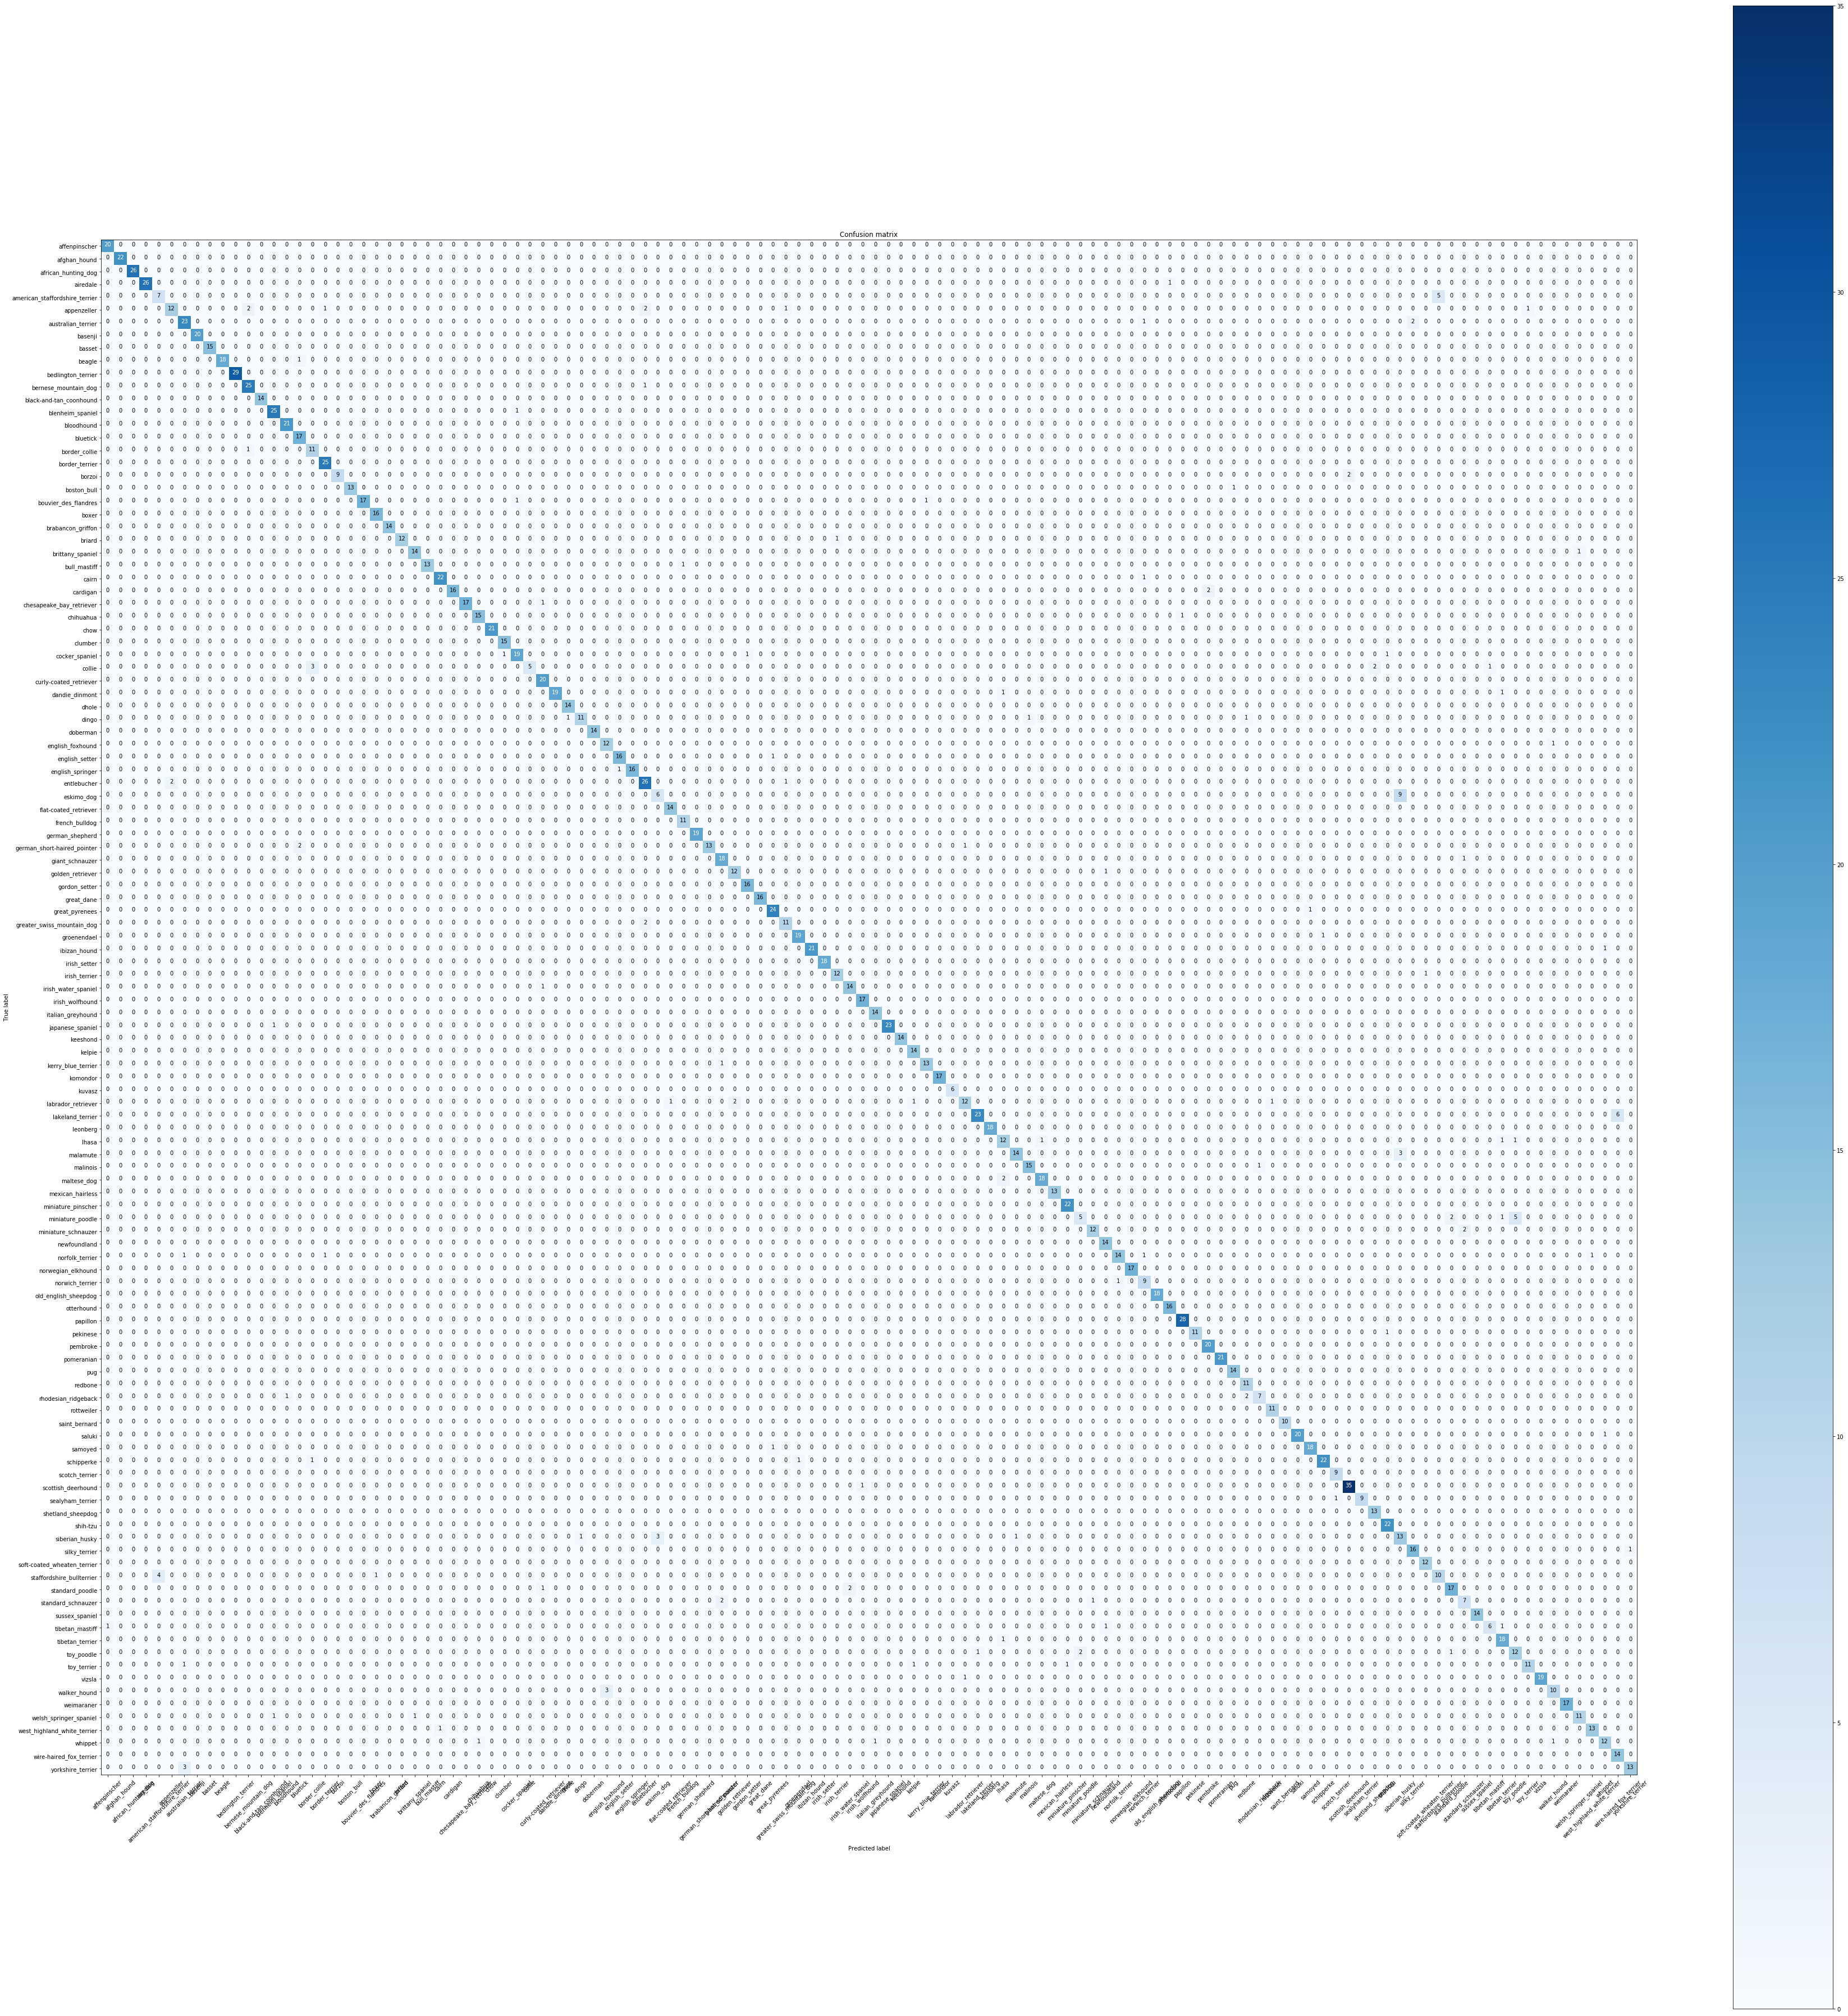

In [419]:
plot_confusion_matrix(cm, data.classes, figsize=(50,50))

## Visualization

In [561]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    print(title)
    imgs = [Image.open(f'{PATH}{data.val_ds.fnames[x]}') for x in idxs]
    title_probs = []
    
    for x in idxs:
        predicted_class_name = data.classes[preds[x]]
        actual_class_name = data.classes[data.val_y[x]]
        probability = probs[x][preds[x]]
        title_probs.append(f'predicted: {predicted_class_name} \n actual: {actual_class_name}\n ({str(probability)})')
        
    return plots(imgs, rows=1, titles=title_probs)

def plots(imgs, figsize=(20,20), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(np.asarray(imgs[i]))

def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def filter_by_class_name(idxs, class_name):
    class_filtered_idxs_list = []
    
    for idx in idxs:
        if(class_name is None or class_name == data.classes[data.val_y[idx]]):
            class_filtered_idxs_list.append(idx)
    
    return np.asarray(class_filtered_idxs_list)

def most_by_mask(mask, class_name):
    idxs = np.where(mask)[0]
    class_filtered_idxs = filter_by_class_name(idxs, class_name)         
    masked_idxs = class_filtered_idxs[np.argsort([np.max(probs[idx]) for idx in class_filtered_idxs])[-4:]]
    return masked_idxs

def most_by_correct(is_correct, class_name=None): 
    return most_by_mask((preds == data.val_y)==is_correct, class_name=class_name)

def most_by_uncertain(class_name): 
    idxs = np.where(preds==preds)[0]
    class_filtered_idxs = filter_by_class_name(idxs, class_name)  
    masked_idxs = class_filtered_idxs[np.argsort([np.abs(1-np.max(probs[idx])) for idx in class_filtered_idxs])[-4:]]
    return masked_idxs

Most incorrect


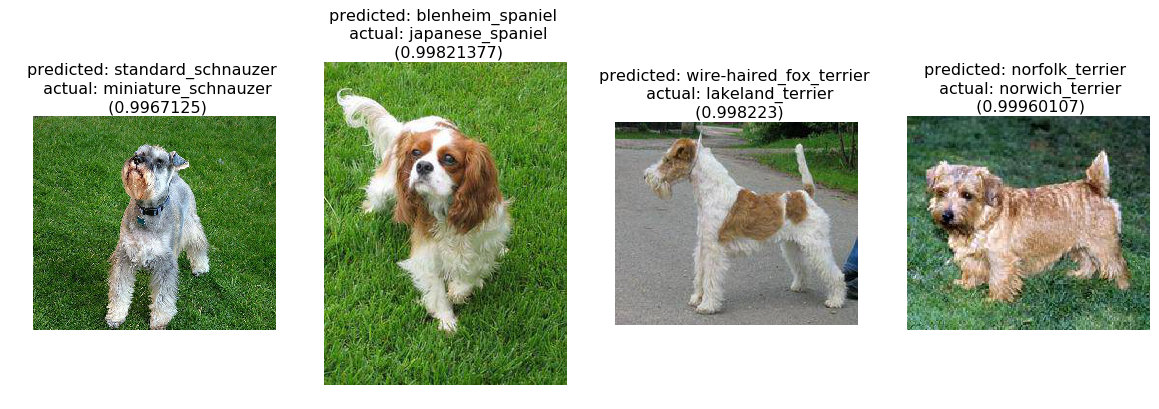

In [552]:
plot_val_with_title(most_by_correct(False), "Most incorrect")

Most incorrect by class: Norfock Terrier


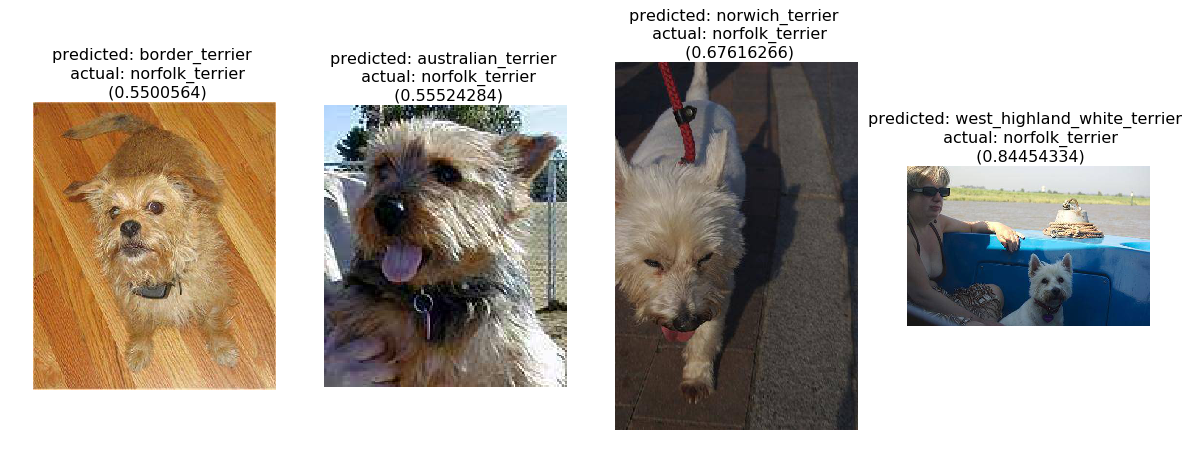

In [553]:
plot_val_with_title(most_by_correct(False, "norfolk_terrier"), "Most incorrect by class: " + "Norfock Terrier")

Most correct


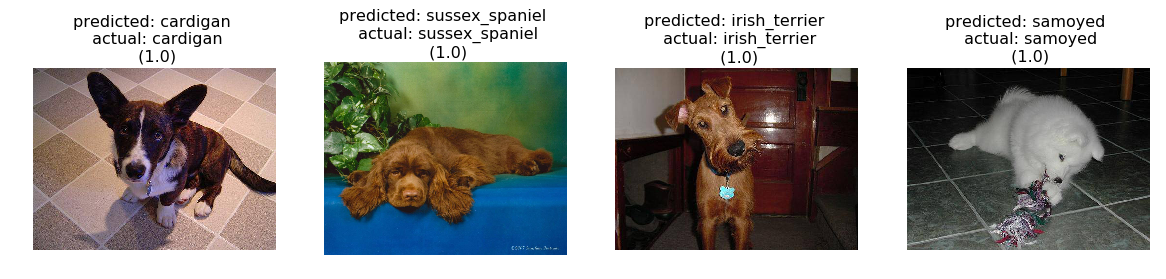

In [554]:
plot_val_with_title(most_by_correct(True), "Most correct")

Most correct by class: Norfock Terrier


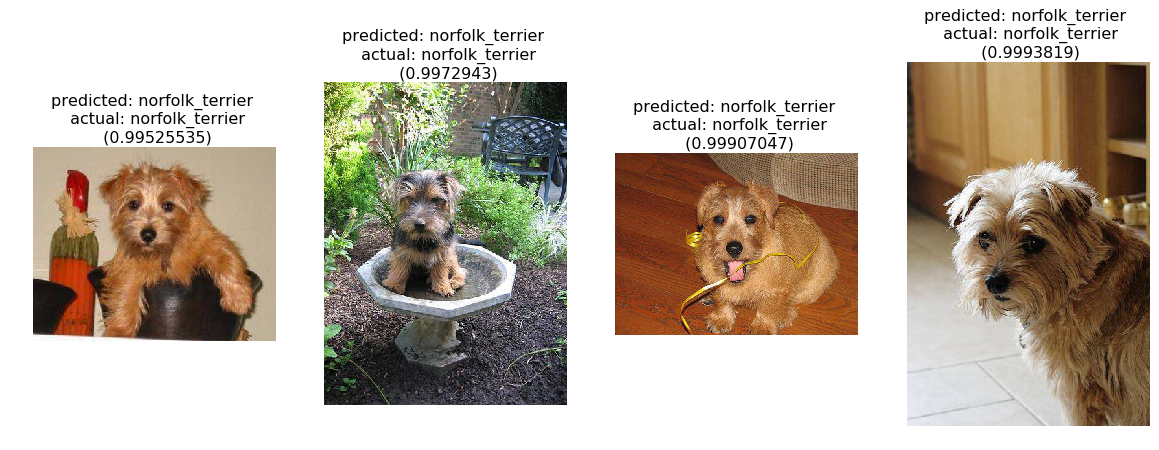

In [555]:
plot_val_with_title(most_by_correct(True, "norfolk_terrier"), "Most correct by class: " + "Norfock Terrier")

Most uncertain by class: Norfock Terrier


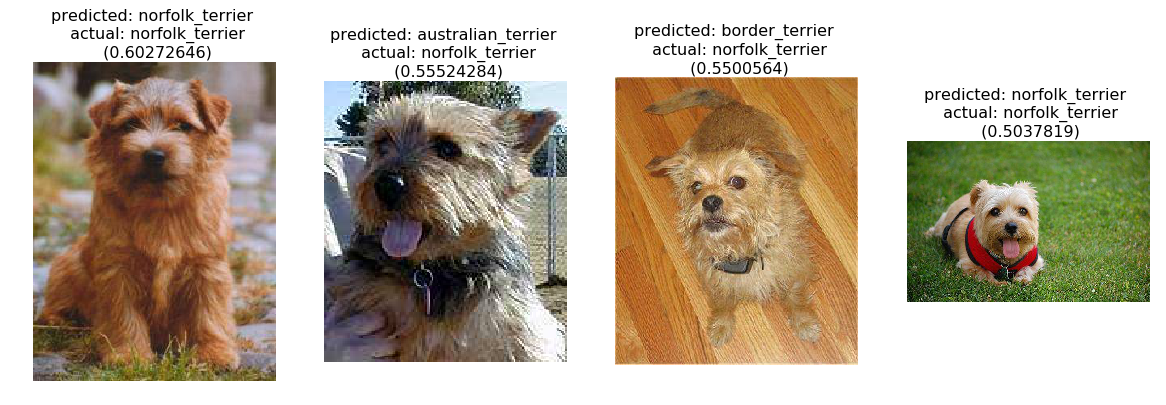

In [562]:
plot_val_with_title(most_by_uncertain("norfolk_terrier"), "Most uncertain by class: " + "Norfock Terrier")

Most uncertain


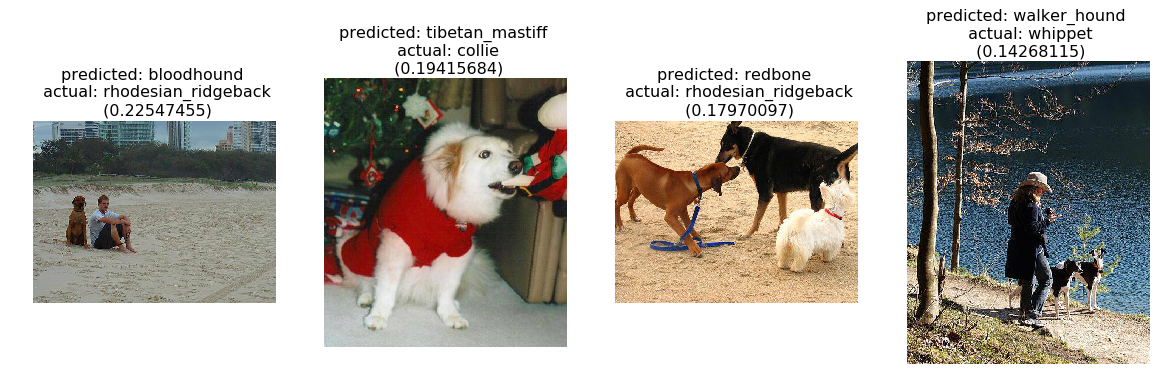

In [563]:
plot_val_with_title(most_by_uncertain(None), "Most uncertain")

## Single Photo Prediction

In [558]:
sz=299
learn.load(f'{sz}')

def get_predicted_breed_num(photo_path):
    trn_tfms, val_tfms = tfms_from_model(f_model,sz)
    im = val_tfms(open_image(photo_path))
    preds = learn.predict_array(im[None])
    return np.argmax(preds)

def get_image_path_for_predicted_breed(predicted_class_num):
    matching_image_file = None
    data.val_ds.fnames

    index = 0
    for x,y in data.val_ds: 
        if y == predicted_class_num:
            return f'{PATH}{data.val_ds.fnames[index]}'
        index = index+1
    return None

def get_displayable_image(photo_path, max_dimension=300):
    raw_image = Image.open(photo_path)
    max_dimension = 300
    resize_ratio = max_dimension/max(raw_image.size)
    size = (int(raw_image.size[0]*resize_ratio), int(raw_image.size[1]*resize_ratio))
    return raw_image.resize(size, Image.ANTIALIAS)
    

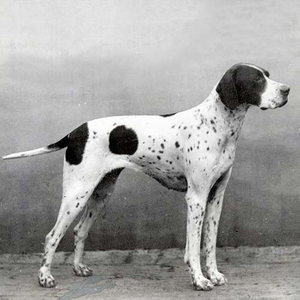

In [559]:
photo_upload_folder=f'{PATH}image uploads/'
photo_name='EnglishPointer.jpg'
photo_path=f'{photo_upload_folder}{photo_name}'
get_displayable_image(photo_path)

german_short-haired_pointer


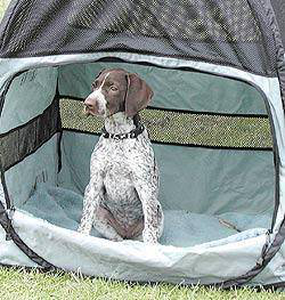

In [560]:
predicted_class_num = get_predicted_breed_num(photo_path)
predicted_class_name = data.classes[predicted_class_num]
print(predicted_class_name)
matching_image_file = get_image_path_for_predicted_breed(predicted_class_num)
get_displayable_image(matching_image_file)        